# Preprocessing

---

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
files = pd.read_csv("data/new_metadata.csv")

In [3]:
files

,hasCreator,isAuthorCreator,CreatorTool,Producer,hasWarning,TaggedPDF,hasTitle,hasKeywords,hasSubject,hasDescription,...,hasXMPToolkit,ModificationTZ,CreationYear,ModificationYear,CreateDate,ModifyDate,PageCount,FileSize,LenFileName,Label
0,False,True,Other,Acrobat Distiller 5.0,False,False,True,False,False,False,...,True,UTC\-04:00,2006,2006,2006-03-30 14:09:13+00:00,2006-04-06 08:48:54-04:00,34.0,388.0,13,Benign
1,False,True,Other,Acrobat Distiller 6.0.1,False,False,True,False,False,False,...,True,UTC\-04:00,2006,2010,2006-04-05 09:30:37-04:00,2010-03-22 11:18:17-04:00,29.0,245.0,12,Benign
2,False,True,Other,Acrobat Distiller 6.0,False,False,True,False,False,False,...,True,UTC\-04:00,2005,2005,2005-09-28 08:16:58-04:00,2005-09-28 08:16:58-04:00,34.0,241.0,12,Benign
3,False,False,Unknown,Acrobat PDFWriter 5.0,False,False,True,False,False,False,...,False,Unknown,2004,Unknown,2004-09-30 13:47:07,NaN,59.0,359.0,10,Benign
4,False,True,Unknown,Acrobat Distiller 4.0,False,False,True,True,True,True,...,False,UTC\-04:00,2000,2002,2000-02-10 09:37:43+00:00,2002-04-29 11:59:37-04:00,5.0,32.0,7,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,True,False,Unknown,Unknown,True,False,False,False,False,False,...,False,Unknown,Unknown,Unknown,NaN,NaN,0.0,299.0,44,Malware
19975,True,False,Unknown,Unknown,True,False,False,False,False,False,...,False,Unknown,Unknown,Unknown,NaN,NaN,0.0,9.6,44,Malware
19976,True,False,Unknown,Unknown,True,False,False,False,False,False,...,False,Unknown,Unknown,Unknown,NaN,NaN,0.0,15.0,44,Malware
19977,True,False,Unknown,Unknown,True,False,False,False,False,False,...,False,Unknown,Unknown,Unknown,NaN,NaN,0.0,7.5,44,Malware


## Normalization study

As there are few numeric variables, and that they are mixed with categorical variables we should study their distribution to see how to normalize those if it is needed by the chosen classifier.

### File Size

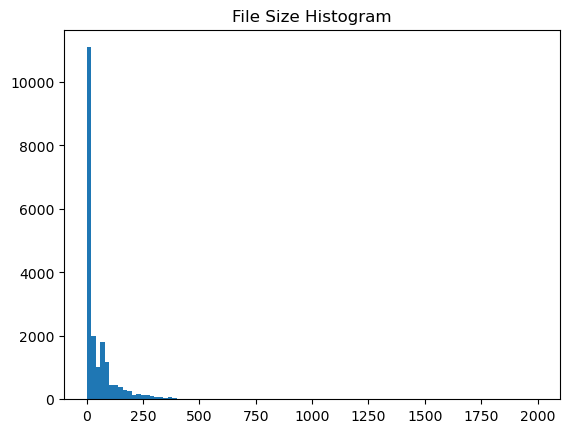

In [4]:
plt.hist(files.FileSize, bins=100)
plt.title('File Size Histogram')
plt.show()

### Page Count

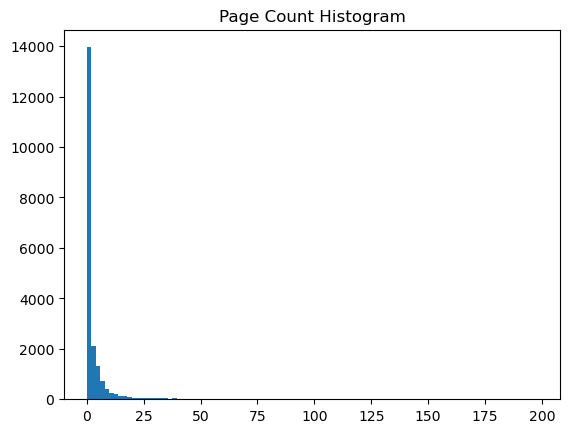

In [5]:
plt.hist(files.PageCount, bins=100)
plt.title('Page Count Histogram')
plt.show()

### File name length

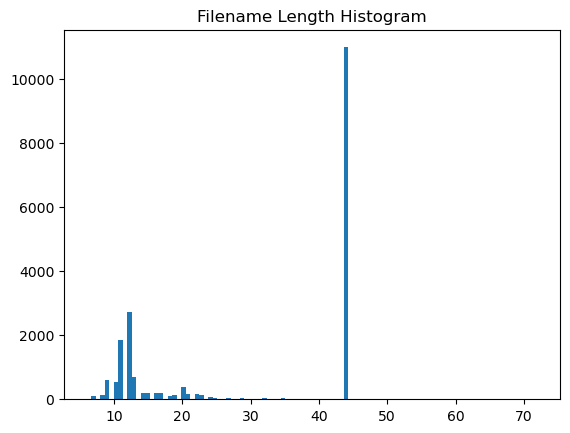

In [6]:
plt.hist(files.LenFileName, bins=100)
plt.title('Filename Length Histogram')
plt.show()

## Feature correlation

In [7]:
from sklearn import preprocessing
from scipy.stats import chi2_contingency
import seaborn as sns

In [8]:
non_num_features = [
    "hasCreator", "isAuthorCreator", "ModificationTZ", "CreatorTool",  
    "TaggedPDF", "hasTitle", "hasKeywords", "hasSubject", "CreationYear", 
    "ModificationYear", "Linearized", "PDFVersion", "HasXFA"
]

In [9]:
num_features = ["PageCount", "FileSize"]

#### Categorical features

In [10]:
labelEnc = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 
data = files[non_num_features]
for i in data.columns :
  data_encoded[i]=labelEnc.fit_transform(data[i])

In [11]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [12]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

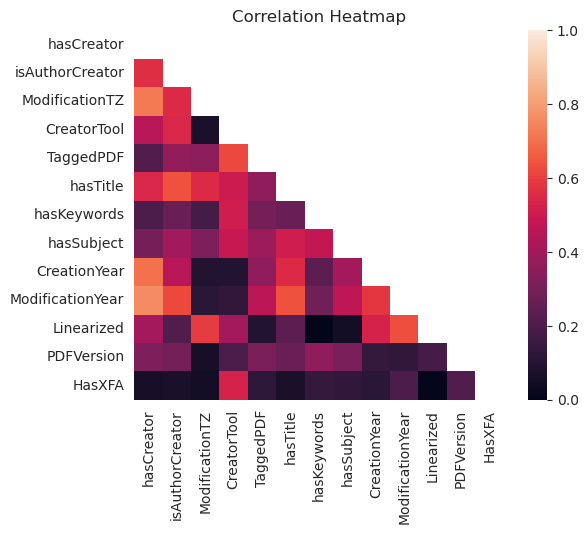

In [13]:
mask = np.zeros_like(df, dtype="bool")
mask[np.triu_indices_from(mask)] = True

plt.figure()
with sns.axes_style("white"):
  ax = sns.heatmap(df, mask=mask,vmin=0., vmax=1, square=True)
plt.title("Correlation Heatmap")
plt.show()

#### Numerical features

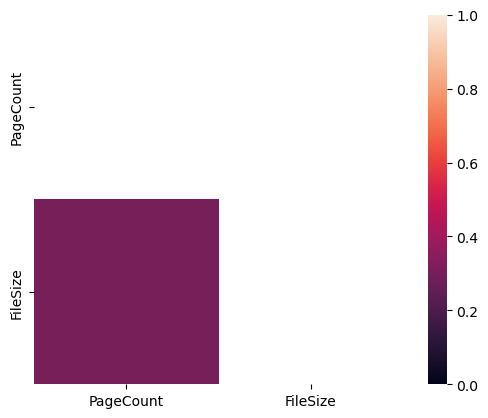

In [14]:
data = files[num_features]
df = data.corr()

mask = np.zeros_like(df, dtype="bool")
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df, mask=mask, vmin=0, vmax=1, square=True);
plt.show()

## Conversion to numeric array 

Convert the pandas array to a np.array that can be used by the `sklearn` machine learning module 

#### Categorical features

In [15]:
non_num_df = files[non_num_features].copy()

non_num_df = pd.get_dummies(non_num_df) * 1 # one-hot encoding + conversion of boolean to integers

#### Numerical features

In [16]:
num_df = files[num_features].copy()

num_df = (num_df - num_df.min(axis=0)) / (num_df.max(axis=0) - num_df.min(axis=0)) # Normalization

#### Array & Labels

In [17]:
df = non_num_df.join(num_df, how = 'inner')

X = df.values
columns = df.columns
y = files.Label.map(lambda x: int(x == "Malware")).values

## Split train/test

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .7)

In [20]:
# Training set
np.save("data/train_set.npy", X_train)
np.save("data/train_labels.npy", y_train)

# Testing set
np.save("data/test_set.npy", X_test)
np.save("data/test_labels.npy", y_test)

# Column names
np.save("data/columns.npy", columns)